In [2]:
!pip install git+https://github.com/qubvel/classification_models.git
!pip install keras-radam
!pip install adabelief-tf==0.1.0
!pip install keras-rectified-adam
!pip install keras-adabound
!pip install git+https://github.com/tensorflow/addons

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-k3wv6y7x
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-k3wv6y7x
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 50 kB 2.4 MB/s eta 0:00:011
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-py3-none-any.whl size=20030 sha256=64dfceaf52ff31dc44ce0a8ccdf64bf9c8a5a7892614be28a7f45c95ea868641
  Stored in directory: /tmp/pip-ephem-wheel-cache-p7vphovx/wheels/0b/96/56/27b17c903efc647c51e4f364bfc20aa67f8d3dccad63c4fb4e
Successfully built image-classifiers
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
  Created wheel for keras-radam: filename=keras_radam-0.15.0-py3-none-any.whl size=14684 sha256=d55dfcf36273c2ae89dd2a3cdc38ee210af7fbb875fe3957276b8c86d7b97811
  Stored in directory: /root/.cache/pip/wheels/23/6a/5f/d674f3b7b4d5

In [3]:
from classification_models.keras import Classifiers
import numpy as np
np.random.seed(123)  # for reproducibility
import IPython.display as ipd
import librosa
import os
import librosa.display
import pandas as pd
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Embedding
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from adabelief_tf import AdaBeliefOptimizer
from keras_radam.training import RAdamOptimizer
from keras_adabound import AdaBound
import tensorflow_addons
from keras.layers import LSTM,Input

In [4]:
import IPython.display as ipd
import librosa
import os
import librosa.display

df = pd.read_csv("../input/urbansound8k/UrbanSound8K.csv")
df['class'].value_counts()
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

extracted_features=[]
for i in range(8732):
    file_name = '../input/urbansound8k/fold' + str(df["fold"][i]) + '/' + df["slice_file_name"][i]
    final_class_labels=df["class"][i]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])
    
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

y=np.array(pd.get_dummies(y))

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=0,stratify=y)
num_labels=y.shape[1]


/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1323
  n_fft, y.shape[-1]
/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1103
  n_fft, y.shape[-1]
/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1523
  n_fft, y.shape[-1]


In [5]:
X_train = X_train.reshape(7422,1, 40)
print(X_train.shape)
print(X_train)

(7422, 1, 40)
[[[-2.7773288e+02  1.7517300e+02 -4.2753883e+01 ... -3.1237578e+00
   -1.6546676e+00  3.4935132e-02]]

 [[-1.7629185e+02  5.4210773e+01 -1.9680815e+01 ... -6.9663829e-01
   -2.0912175e+00  5.0977793e-02]]

 [[-8.2521469e+01 -4.8062816e+00 -3.0166693e+01 ... -5.0011510e-01
   -4.2660084e+00  1.0271890e+00]]

 ...

 [[-2.9528183e+02  1.8482365e+02  3.7392338e+01 ... -4.7907820e+00
   -3.2291219e-01 -3.8319535e+00]]

 [[-1.5546674e+02  1.8514043e+02 -7.3052811e+01 ... -5.8431584e-01
   -4.9604946e-01 -1.1271569e+00]]

 [[-1.3009134e+02  2.2065085e+02 -9.2942184e+01 ... -5.5950493e-01
   -1.8734983e+00 -2.2867139e-01]]]


In [6]:
y_train = y_train.reshape(7422,1, 10)
print(y_train.shape)
print(y_train)

(7422, 1, 10)
[[[0 0 0 ... 0 1 0]]

 [[0 0 0 ... 1 0 0]]

 [[0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 1 0]]

 [[0 0 0 ... 0 1 0]]]


In [7]:
X_test = X_test.reshape(1310,1, 40)
print(X_test.shape)
print(X_test)

(1310, 1, 40)
[[[-1.7917386e+02  1.4509854e+02 -2.2263836e+01 ...  2.2358115e+00
    1.8358147e+00  1.5545394e+00]]

 [[-5.0195483e+02  1.0645841e+02 -1.7951689e+01 ...  1.5731165e+00
    4.7474980e-01 -5.6550258e-01]]

 [[-9.6924889e+01  1.3063159e+02 -3.5026100e+01 ...  4.3950253e+00
    5.0062666e+00 -1.4872652e+00]]

 ...

 [[-4.0745871e+02  1.5077046e+02  3.0509941e+01 ... -2.3364253e+00
   -4.6394424e+00 -2.7773197e+00]]

 [[-1.0437045e+02  9.1468712e+01 -2.0452114e+01 ...  1.8135097e+00
   -3.4435124e+00  1.7622923e+00]]

 [[-4.4422647e+02  1.1368853e+02 -4.0818207e+01 ...  6.9755244e-01
   -4.4314594e+00 -1.9911759e-01]]]


In [8]:
y_test = y_test.reshape(1310,1,10)
print(y_test.shape)
print(y_test)

(1310, 1, 10)
[[[0 0 0 ... 0 0 0]]

 [[0 0 1 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 [[0 0 1 ... 0 0 0]]]


In [9]:
from keras.layers import LSTM,Input

# Model
model = Sequential()
model.add(LSTM(40,input_shape=(1,40), return_sequences=True))
model.add(LSTM(40,input_shape=(1,40),return_sequences=True))
model.add(Dense(512,activation ='relu'))
model.add(Dropout(0.2))
model.add(Dense(10,activation ='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 40)             12960     
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 40)             12960     
_________________________________________________________________
dense (Dense)                (None, 1, 512)            20992     
_________________________________________________________________
dropout (Dropout)            (None, 1, 512)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 10)             5130      
Total params: 52,042
Trainable params: 52,042
Non-trainable params: 0
_________________________________________________________________


Please check your arguments if you have upgraded adabelief-tf from version 0.0.1.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  -------------
adabelief-tf=0.0.1       1e-08  Not supported      Not supported
Current version (0.1.0)  1e-14  supported          default: True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

-------------------------------------optimizer = Adam-------------------------------------
Epoch 1/100
232/232 [==============================] - 5s 9ms/step - loss: 2.0213 - accuracy: 0.2914 - val_loss: 1.4707 - val_accuracy: 0.4832
Epoch 2/100
232/232 [==============================] - 1s 4ms/step - loss: 1.3065 - accuracy: 0.5518 - val_loss: 1.1970 - val_accuracy: 0.5969
Epoch 3/100
232/232 [==============================] - 1s 5ms/step - loss: 1.0873 - accuracy: 0.6314 - val_loss: 1.1072 - val_accuracy: 0.6

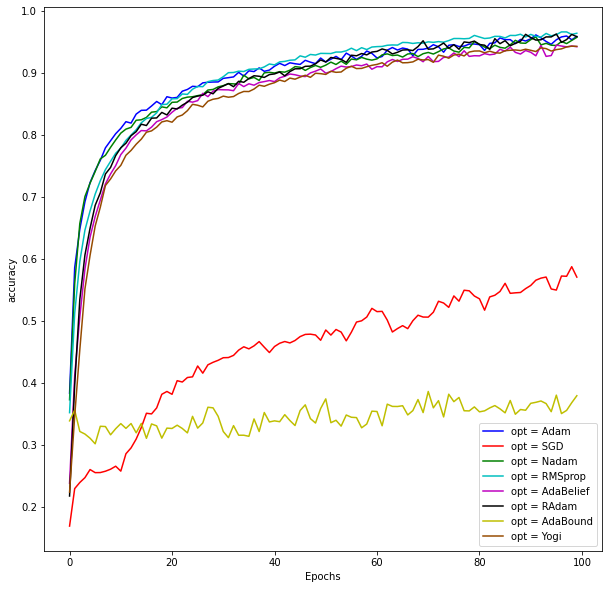

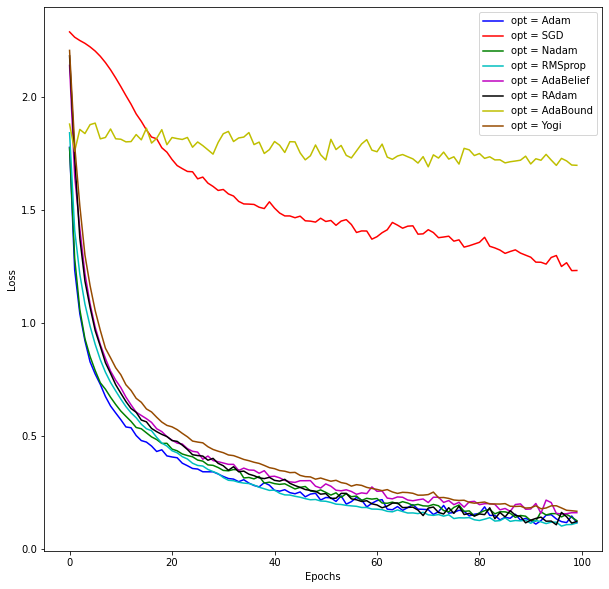

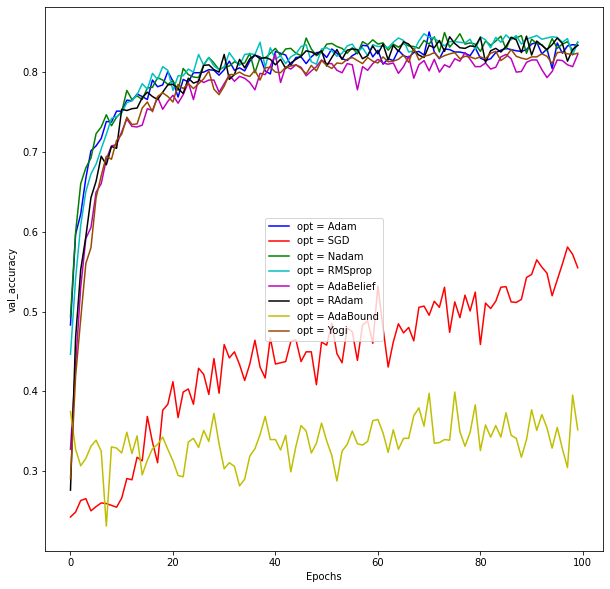

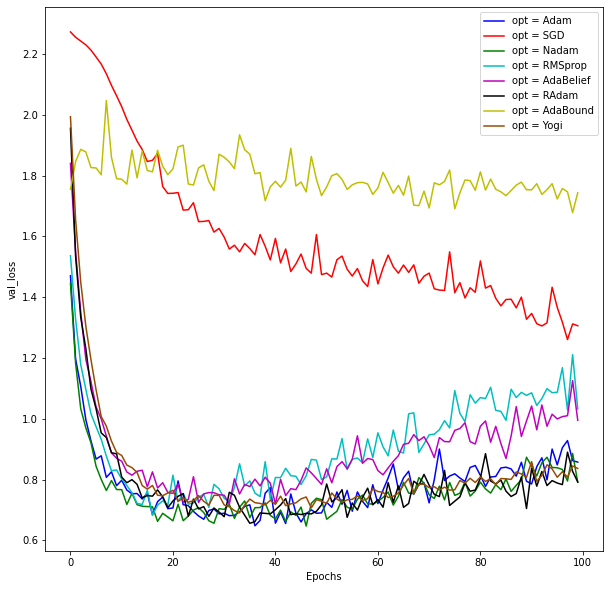

In [10]:
k = []
ok = 0
yes = 0
zet = 0
yep = 0


opt =  [keras.optimizers.Adam(learning_rate=0.001),
                  keras.optimizers.SGD(learning_rate=0.01),
                  keras.optimizers.Nadam(learning_rate=0.001),
                  keras.optimizers.RMSprop(learning_rate=0.001),
                  AdaBeliefOptimizer(learning_rate=0.001),
                  RAdamOptimizer(learning_rate=0.001),
                  AdaBound(learning_rate=0.001, final_lr=0.1),
                  tensorflow_addons.optimizers.yogi.Yogi(learning_rate=0.001)]
        
for t in opt:
    del model
    #del base_model
    #del x
    #del output
    if (t == opt[0]):
        print("-------------------------------------optimizer = Adam-------------------------------------")
    elif (t == opt[1]):
            print("-------------------------------------optimizer = SGD-------------------------------------")
    elif (t == opt[2]):
            print("-------------------------------------optimizer = Nadam-------------------------------------")
    elif (t == opt[3]):
            print("-------------------------------------optimizer = RMSprop-------------------------------------")
    elif (t == opt[4]):
            print("-------------------------------------optimizer = AdaBelief-------------------------------------")
    elif (t == opt[5]):
            print("-------------------------------------optimizer = RAdam-------------------------------------")

    elif (t == opt[6]):
            print("-------------------------------------optimizer = AdaBound-------------------------------------")

    elif (t == opt[7]):
            print("-------------------------------------optimizer = Yogi-------------------------------------")

    model = Sequential()
    model.add(LSTM(40,input_shape=(1,40), return_sequences=True))
    model.add(LSTM(40,input_shape=(1,40),return_sequences=True))
    model.add(Dense(512,activation ='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10,activation ='softmax'))
    # 8. Compile model
    model.compile(loss='categorical_crossentropy',
              optimizer = t,
              metrics=['accuracy'])


       # 9. Fit model on training data
    k.append(model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test),verbose=1))



while (ok<len(k)):  



    plt.figure(figsize=(10,10))
    plt.plot(k[ok+0].history['accuracy'],color='b', label="opt = Adam")
    plt.plot(k[ok+1].history['accuracy'],color='r', label="opt = SGD")
    plt.plot(k[ok+2].history['accuracy'],color='g', label="opt = Nadam")
    plt.plot(k[ok+3].history['accuracy'],color='c', label="opt = RMSprop")
    plt.plot(k[ok+4].history['accuracy'],color='m', label="opt = AdaBelief")
    plt.plot(k[ok+5].history['accuracy'],color='k', label="opt = RAdam")
    plt.plot(k[ok+6].history['accuracy'],color='y', label="opt = AdaBound")
    plt.plot(k[ok+7].history['accuracy'],color='#964B00', label="opt = Yogi")
    
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show() 

    ok +=8







while (yes<len(k)):   



    plt.figure(figsize=(10,10))
    plt.plot(k[yes+0].history['loss'],color='b', label="opt = Adam")
    plt.plot(k[yes+1].history['loss'],color='r', label="opt = SGD")
    plt.plot(k[yes+2].history['loss'],color='g', label="opt = Nadam")
    plt.plot(k[yes+3].history['loss'],color='c', label="opt = RMSprop")
    plt.plot(k[yes+4].history['loss'],color='m', label="opt = AdaBelief")
    plt.plot(k[yes+5].history['loss'],color='k', label="opt = RAdam")
    plt.plot(k[yes+6].history['loss'],color='y', label="opt = AdaBound")
    plt.plot(k[yes+7].history['loss'],color='#964B00', label="opt = Yogi")
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show() 

    yes+=8




while (zet<len(k)):   



    plt.figure(figsize=(10,10))
    plt.plot(k[zet+0].history['val_accuracy'],color='b', label="opt = Adam")
    plt.plot(k[zet+1].history['val_accuracy'],color='r', label="opt = SGD")
    plt.plot(k[zet+2].history['val_accuracy'],color='g', label="opt = Nadam")
    plt.plot(k[zet+3].history['val_accuracy'],color='c', label="opt = RMSprop")
    plt.plot(k[zet+4].history['val_accuracy'],color='m', label="opt = AdaBelief")
    plt.plot(k[zet+5].history['val_accuracy'],color='k', label="opt = RAdam")
    plt.plot(k[zet+6].history['val_accuracy'],color='y', label="opt = AdaBound")
    plt.plot(k[zet+7].history['val_accuracy'],color='#964B00', label="opt = Yogi")
    
    plt.xlabel('Epochs')
    plt.ylabel('val_accuracy')
    plt.legend()
    plt.show() 

    zet+=8





while (yep<len(k)):   



    plt.figure(figsize=(10,10))
    plt.plot(k[yep+0].history['val_loss'],color='b', label="opt = Adam")
    plt.plot(k[yep+1].history['val_loss'],color='r', label="opt = SGD")
    plt.plot(k[yep+2].history['val_loss'],color='g', label="opt = Nadam")
    plt.plot(k[yep+3].history['val_loss'],color='c', label="opt = RMSprop")
    plt.plot(k[yep+4].history['val_loss'],color='m', label="opt = AdaBelief")
    plt.plot(k[yep+5].history['val_loss'],color='k', label="opt = RAdam")
    plt.plot(k[yep+6].history['val_loss'],color='y', label="opt = AdaBound")
    plt.plot(k[yep+7].history['val_loss'],color='#964B00', label="opt = Yogi")
    
    plt.xlabel('Epochs')
    plt.ylabel('val_loss')
    plt.legend()
    plt.show() 

    yep+=8